# Milestone 1 - Chicago, U.S. bikesharing

`Source`: 
https://data.cityofchicago.org/Transportation/Divvy-Trips/fg6s-gzvg/about_data 

`Mobility domain`:
https://data.cityofchicago.org/

`Github repository`:
https://github.com/kbui-03/ChicagoBikeProject


# Target feature of the model: `TRIP DURATION` 

By predicting the duration of each trip, we can:
+ Optimise charging times of electric bikes
+ Present customers with an estimated payment recommendation
+ Reduce bike shortages in rush hour
+ Provide the City of Chicago with data, which could be used to improve public transportation, healthcare, or public outreach  

# Data preparation

Since the dataset given has a total of roughly **21 million rows**, we need to reduce the size of the data before downloading. In order to do that, we used the provided query function to filter the rows: 

`TRIP_ID` is greater than or equal to 22,000,000 AND

`TRIP_ID` is less than or equal to 22,200,000

This left us with about roughly 170.000 unique bike rides to work with, in the time frame of March 2019. We hypothesise that March is a good general representative of the whole year for a model to learn from, since:
+ It represents the switch from cold winter months to warmer summer/spring weather, the model therefore might learn to account for these temperature changes 
+ In the same vein, the amount of precipitation/snow also represents a switch from rainy/snowy winter to sunny summer. The model should, in theory, learn these patterns 

**Source**: https://www.ncei.noaa.gov/access/services/data/v1?dataset=normals-monthly-1991-2020&startDate=0001-01-01&endDate=9996-12-31&stations=USC00111577&format=pdf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bike_set = pd.read_csv("Divvy_Trips_Chicago.csv", sep=",")
bike_set.info()

# Cleaning the dataset
**Row-wise deletion**

We can observe that there are rows missing `TO LATITUDE`, `TO LONGITUDE`, `TO LOCATION`, `FROM LATITUDE`, `FROM LONGITUDE` and `FROM LOCATION`. These few rows (four to ten rows) can be deleted without a significant impact on the general dataset.

A larger portion of missing values can be seen for the columns `GENDER` and `BIRTH YEAR`. Here, a larger amount of rows, roughly 12,000 to 13,000 rows, are missing. One possible solution for dealing with the missing values is by **imputation**. In this case, it has been suggested to analyze the ratio of male to female bike riders and distribute the rows with missing genders accordingly. But due to the size of missing values we, as a group, have decided to delete them instead, in order to keep the integrity of the dataset as well as the correlation to other features. 

Despite the deletion of those rows, the data still contains sufficient observations with over 100,000 rows which fulfills the given minimum observation requirement.


In [ ]:
#deletion of rows with null values
bike_clean_1 = bike_set.dropna()
bike_clean_1.info()

# Feature Selection (column-wise deletion)

**Correlation criteria**: 

- One can observe that `FROM LONGITUDE` and `FROM LATITUDE` are highly correlated to `FROM LOCATION`, which results in redundant information. This also applies to the features `TO LONGITUDE`, `TO LATITUDE` and `TO LOCATION`.
- Also, `FROM STATION ID` and `FROM STATION NAME` as well as `TO STATION ID` and `TO STATION NAME` are highly correlated. Therefore, only one feature of each category is needed.
- `START TIME` in combination with `STOP TIME` provides the similar information value as `TRIP DURATION`. One can extract the duration with these features. Since trip duration is the core of our model and including `STOP TIME` will result in a data leakage, the stop time will be removed. 

---

- The `TRIP ID` does not offer much explanatory power and does not contribute to the predictability of the target feature `TRIP DURATION`. This feature is relevant for uniquely identifying rows while analyzing and processing the data, but not for training the model itself. Hence, this feature will be removed for the cleaned dataset. 
- `TO STATION ID` and `TO STATION NAME` will also be removed from the cleaned dataset since the destination of the trip is not given at the start but rather up to the user. The feature therefore has no use in predicting trip durations. This reasoning also applies to `TO LATITUDE`, `TO LONGITUDE` and `TO LOCATION`. 


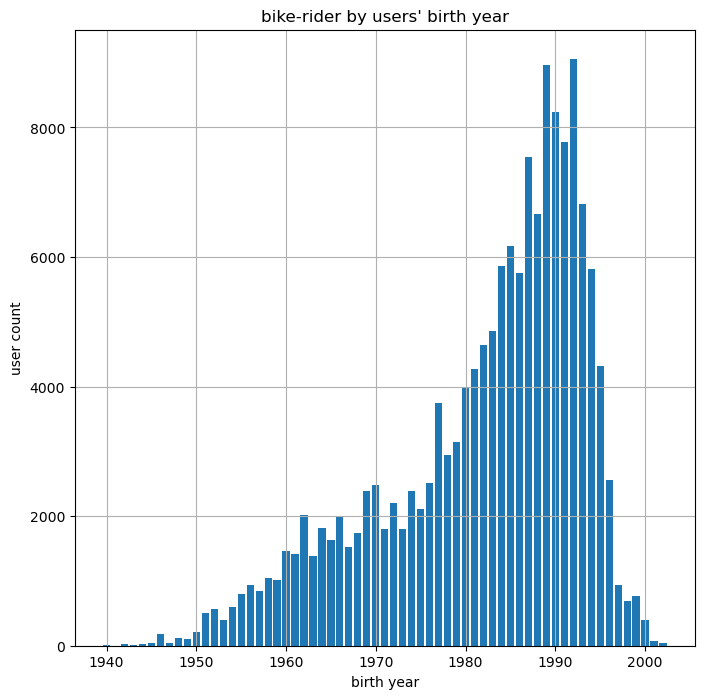

In [57]:
#distribution of birth year
birth_year_counter = bike_clean_1["BIRTH YEAR"].astype(int).value_counts().sort_index()

plt.figure(figsize = (8,8))
plt.bar(birth_year_counter.index, birth_year_counter.values)

plt.xlabel("birth year")
plt.ylabel("user count")
plt.title("bike-rider by users' birth year")
plt.grid()
plt.show()

---
Anomalies in `birth year`   
As one can observe, there are a few outliers in the year 1900 and 1920. It is highly unlikey that a user is older than 105 years and furthermore, the likelihood of a user of that age to ride a bike is even smaller. That is the reason, why these anomalies will be disregarded 

In [ ]:
# remove anomalies in bike data, all rows with birth year before 1940
bike_clean_1 = bike_clean_1[bike_clean_1["BIRTH YEAR"] >= 1940]

# Birth year to age conversion 

Since age is a more general and intuitive feature than birth year, it should be converted. We do this by subtracting 2019 (year of the data set) by `BIRTH YEAR`, afterwards, this column can be safely removed since we have extracted all the necessary information. 

In [ ]:
# converting birth year to age
bike_clean_1["AGE"] = (2019-bike_clean_1["BIRTH YEAR"]).astype(int)

In [ ]:
# distribution of age after clean up
age_counter = bike_clean_1["AGE"].astype(int).value_counts().sort_index()

plt.figure(figsize = (10,8))
plt.bar(age_counter.index, age_counter.values)
plt.xlabel("age")
plt.ylabel("user count")
plt.title("bike-rider by users' age")
# plt.grid()
plt.show()

In [ ]:
bike_clean = bike_clean_1.drop(['TRIP ID', 'STOP TIME','FROM STATION NAME','TO STATION ID',
                               'TO STATION NAME','FROM LOCATION','TO LATITUDE',
                               'TO LONGITUDE','TO LOCATION','BIRTH YEAR'], axis=1)
bike_clean.head()

# Data Engineering Ideas and Progress

Features to **KEEP**:
+ `START TIME`: Has a high variance and provides much explanatory power - **DONE** 
+ `BIKE ID`: Keep for now. While individual bike IDs might not seem predictive, they could capture effects of bike age, maintenance, or type if certain ID ranges correspond to different bike characteristics (though such details are not included in the dataset, further considerations needed)
+ `FROM STATION ID`: Crucial, Trip duration is heavily dependent on its origin. - **DONE** 
+ `USER TYPE`: Important. Subscribers and casual customers often exhibit different usage patterns. - **DONE** 
+ `GENDER`: Potentially useful demographic information. - **DONE** 

Features to **REMOVE**:
+ `TRIP ID`: This is a unique identifier for each row and generally holds no predictive power for the duration of other trips. - **DONE** 
+ `STOP TIME`: Using this directly would be a data leak, as it inherently defines the trip duration when combined with START TIME - **DONE** 
+ `FROM LONGITUDE`, `FROM LATITUDE`: Direct corellation to `STATION ID`, since Divvy bikes can only be picked up/ returned on authorised stations, it is sufficient to then only include `STATION ID`. - **DONE**  (However these features might be important for geographical/ demographic data expansion, this point could be revised in the future if needed)
+ `TO STATION ID`, `TO LATTITUDE`, `TO LONGTITUDE`, `TO LOCATION`: After further research on Divvy services, it seeems the user merely pays for the time frame and not for the distance, since the app won't ask for a destination beforehand (like Uber), therefore the destination cannot be used to predict the duration - **DONE** 
+ `FROM STATION NAME` and `TO STATION NAME`: These are likely redundant if FROM STATION ID and TO STATION ID are clean and used - **DONE**  
+ `FROM LOCATION`: This information is covered by `FROM LONGITUDE` and `FROM LATITUDE` - **DONE** 

Features to **ADD**:
+ Temporal Features (from START TIME):
    + HourOfDay
    + DayOfWeek
    + PartOfDay: Categorical feature (e.g., morning, afternoon, evening, night) based on HourOfDay.
+ AGE, calculated from BIRTH YEAR - **DONE** 
+ Weather Data:
    + Temperature
    + WindSpeed
    + Precipitation
+ Location-based Features:
    + ZoningDesignation (e.g. residential, business)
    + IncomeLevel
    + Other interesting demographic details (if found)